In [0]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from IPython.display import Image
import seaborn as sns
import pydotplus
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix , mean_squared_error
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [725]:
df = pd.read_csv('/content/Carseats.csv')
del df['Unnamed: 0']
len(df.columns)

11

In [726]:
df.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [727]:
df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [728]:
df.shape[0]

400

In [729]:
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


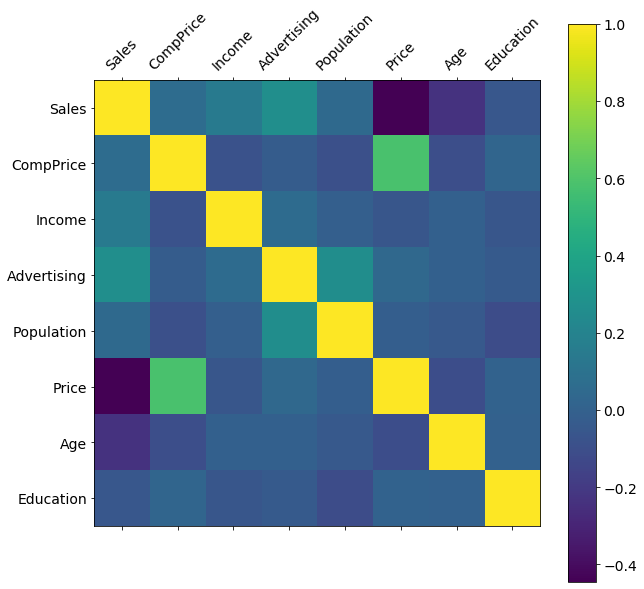

In [730]:
f = plt.figure(figsize=(10,10))
df_corr = df.drop(['Urban', 'US', 'ShelveLoc'], axis=1)
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Text(0.5, 0, 'Unit sales (in thousands) at each location')

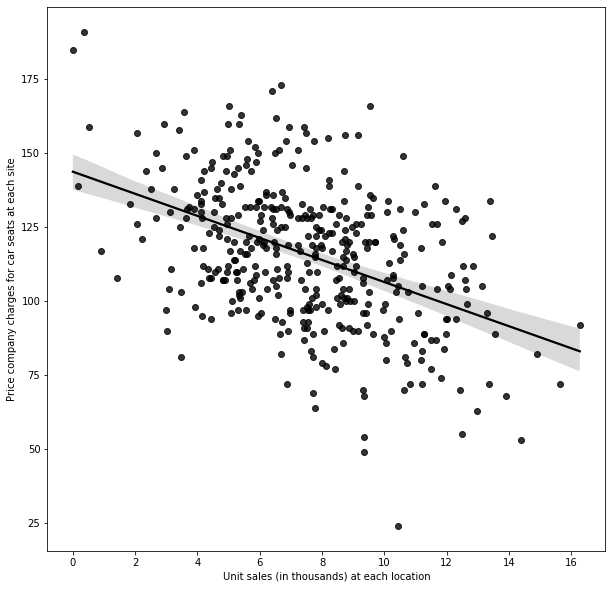

In [731]:
plt.figure(figsize=(10,10))
sns.regplot(x="Sales", y="Price", color="black", data=df);
plt.ylabel("Price company charges for car seats at each site")
plt.xlabel("Unit sales (in thousands) at each location")

From this correlation matrix we can see that the correlation between all of the variables is small apart from Price/Sales and Price/CompPrice. Price has a very negative correlation with sales, the higher the price of the carseat the less sales it has. Price also has a slightly positive correlation with CompPrice meaning the higher the Price the higher the CompPrice. From examining the plotted data we can see that Unit sales increase as price decreases which confirms the negative correlation shown in the correlation matrix 

In [732]:
df['High'] = df.Sales.map(lambda x: 1 if x>8 else 0)
df.ShelveLoc = pd.factorize(df.ShelveLoc)[0]
df.Urban = df.Urban.map({'No':0, 'Yes':1})
df.US = df.US.map({'No':0, 'Yes':1})
X = df.drop(['Sales', 'High'], axis = 1)
y = df.High
print(df.columns)
model = DecisionTreeClassifier(max_depth = 6)
model.fit(X, y)
print(model.score(X, y))

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US', 'High'],
      dtype='object')
0.9175


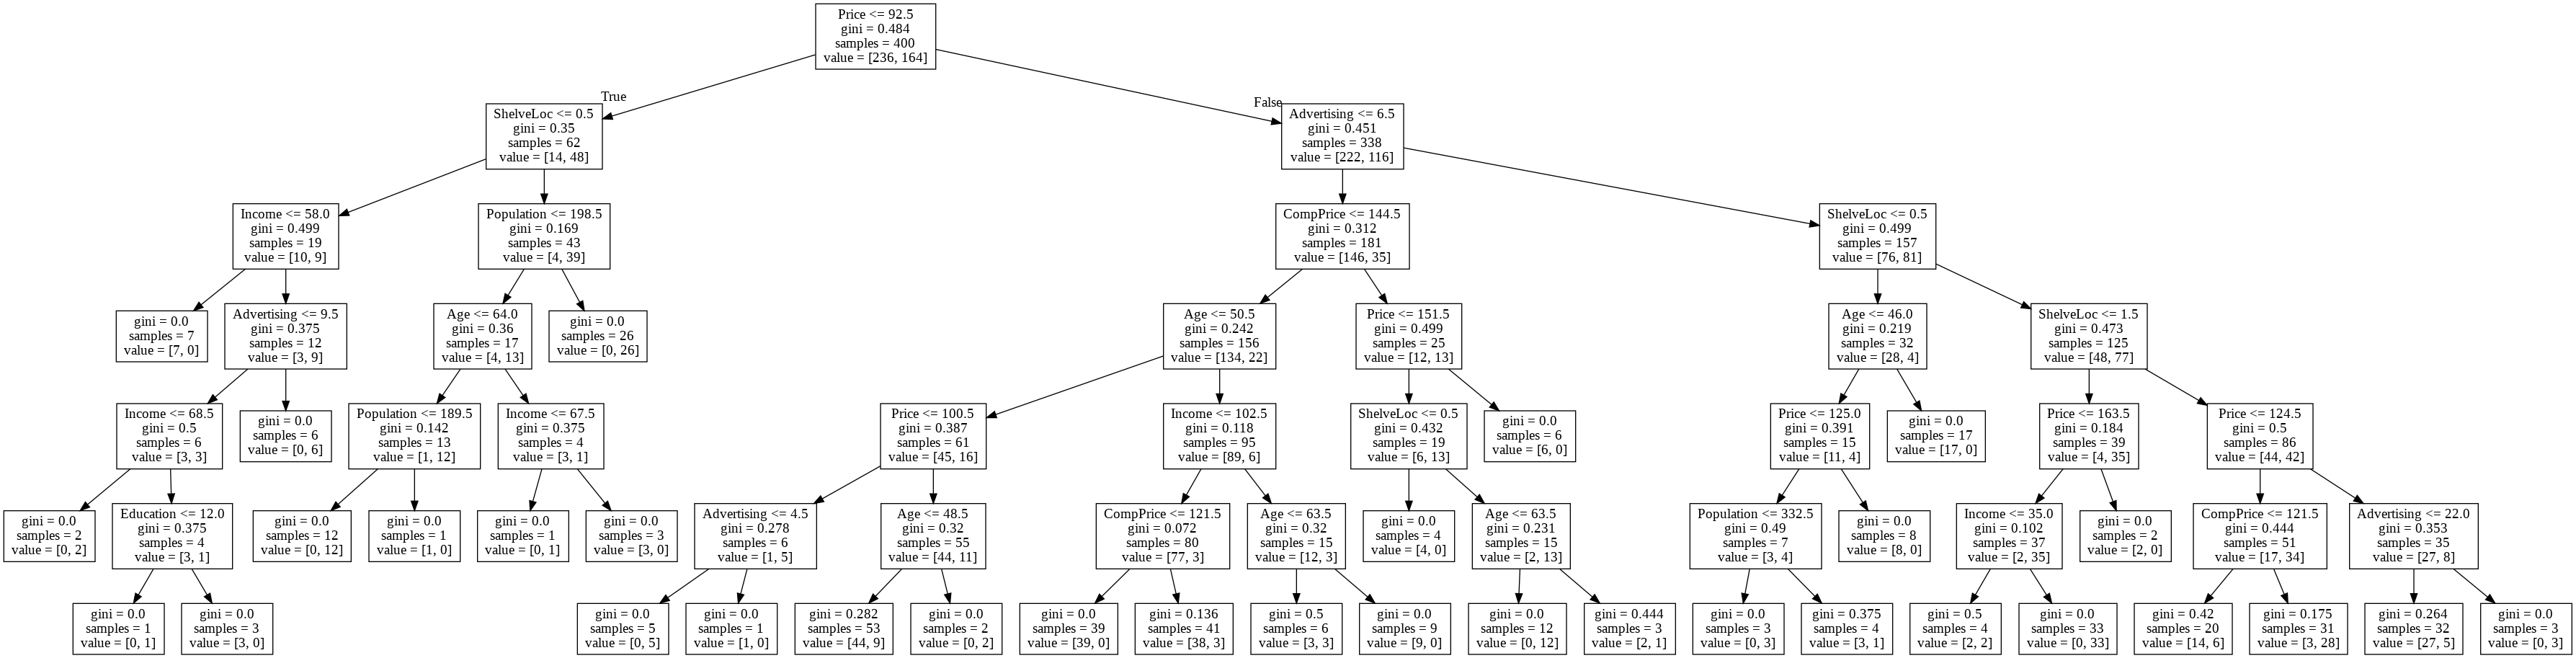

In [733]:
dot_graph = tree.export_graphviz(model, out_file = None, feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_graph)
Image(graph.create_png())

In [0]:
img = Image(graph.create_png())
with open("carseat_tree.png", "wb") as png:
    png.write(img.data)

Since sales is a continuous variable we had created a new binary variable High which has the value Yes if Sales is greater than 8 otherwise it has the value No. We then predict Sales using all of the other variables and get a score of R^2 score of 0.9175

Graphviz and pydotplus lets us visualize the tree which shows number of different information. The first line of the node (such as Price <=92.5) represents a test which based upon the result it either follows the right (if false) or left (if true) path. The gini index shows us the node purity which looks at the number of different classes the node contains. Samples show the number of samples in the current node and values shows the number of samples which fall into each category 

In [735]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
model = DecisionTreeClassifier(max_depth = 6)
model.fit(X_train, y_train)
pred = model.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)

     No  Yes
No   25   10
Yes  18   27


By examining the confusion matrix we can see that the prediction was right 52 times out of 80. This gives us an accuracy of 65%. This can however change depending on the split of training and validation data. 

In [736]:
top_score = 0 
depth = 0
for i in range(1, 30): 
  dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
  dtree.fit(X_train, y_train)
  pred = dtree.predict(X_test)
  print("Depth: " , str(i) ," , Score: " , accuracy_score(y_test, pred))
  if accuracy_score(y_test, pred) > top_score: 
     top_score = accuracy_score(y_test,pred)
     depth = i
print("Best depth: ", depth, " , with Score: ", top_score)

Depth:  1  , Score:  0.6
Depth:  2  , Score:  0.6125
Depth:  3  , Score:  0.725
Depth:  4  , Score:  0.75
Depth:  5  , Score:  0.675
Depth:  6  , Score:  0.6625
Depth:  7  , Score:  0.7875
Depth:  8  , Score:  0.7375
Depth:  9  , Score:  0.725
Depth:  10  , Score:  0.7375
Depth:  11  , Score:  0.725
Depth:  12  , Score:  0.725
Depth:  13  , Score:  0.675
Depth:  14  , Score:  0.75
Depth:  15  , Score:  0.7
Depth:  16  , Score:  0.7
Depth:  17  , Score:  0.725
Depth:  18  , Score:  0.7
Depth:  19  , Score:  0.675
Depth:  20  , Score:  0.7
Depth:  21  , Score:  0.7125
Depth:  22  , Score:  0.725
Depth:  23  , Score:  0.7125
Depth:  24  , Score:  0.7125
Depth:  25  , Score:  0.7625
Depth:  26  , Score:  0.7
Depth:  27  , Score:  0.7125
Depth:  28  , Score:  0.725
Depth:  29  , Score:  0.7625
Best depth:  7  , with Score:  0.7875


The pruning method present in the assignment notebook could not be replicated in Python and therefore i have implemented a method which finds the best max depth for the decision tree classifier. From rerunning the method i can see that all of the depths have a close accuracy score and the best depth varies depending on the data split. The best depth was found to be 7 as it had the highest accuracy score. 

The result of the pruning in the Assignment notebook shows that the tree with 8 terminal nodes performs the best as it has the lowest classification error rate of 75

The two graphs in the assignment notebook show a plot of classification error againts the number of terminal nodes (size) and cost complexity (k). From the left graph we can determine that the lowest classification error occurs for size between 5 and 10 and highest classification occurs between 1 and 5. 

From the right graph we can determine that the lowest classification error occurs for cost complexity ~3 and the highest for cost complexity ~8. 

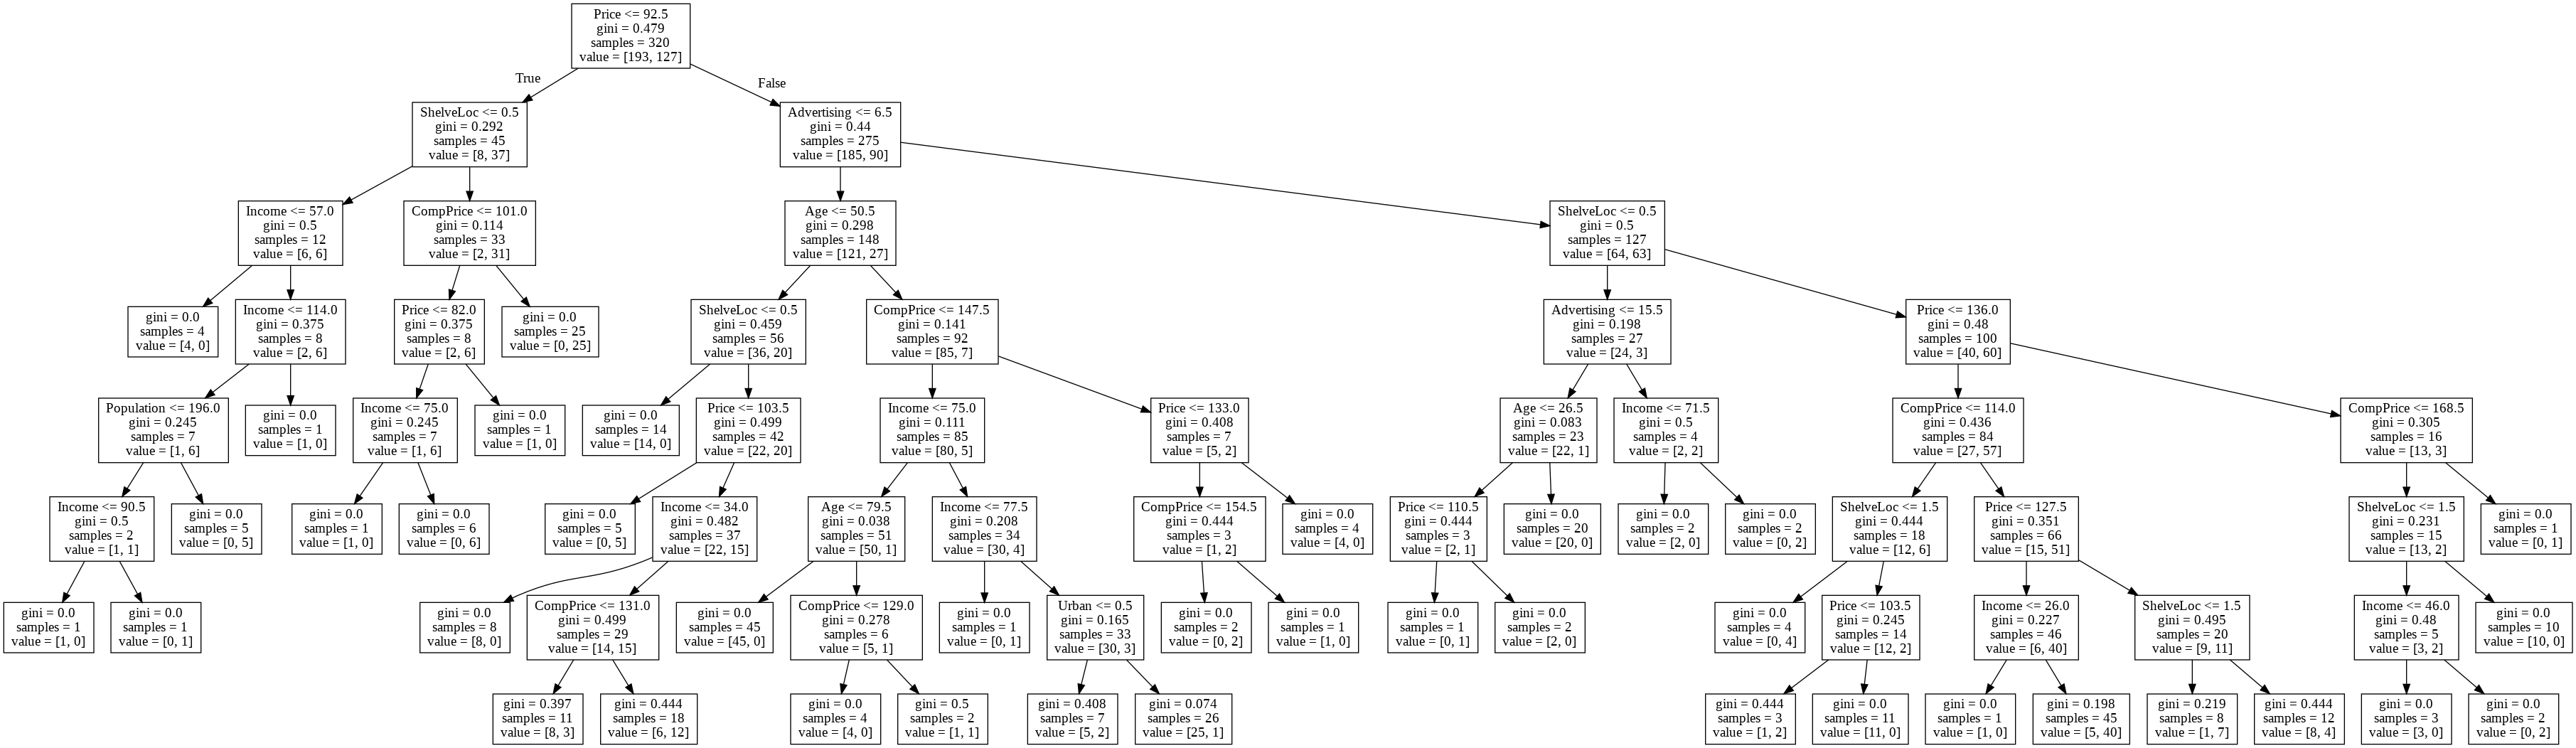

In [737]:
X = df.drop(['Sales', 'High'], axis = 1)
model = DecisionTreeClassifier(max_depth = depth)
model.fit(X_train, y_train)
dot_graph = tree.export_graphviz(model, out_file = None, feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_graph)
Image(graph.create_png())

In [0]:
img = Image(graph.create_png())
with open("carseat_tree2.png", "wb") as png:
    png.write(img.data)

In [739]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index = ['No', 'Yes'], columns = ['No', 'Yes'])
print(cm)

     No  Yes
No   35   11
Yes   8   26


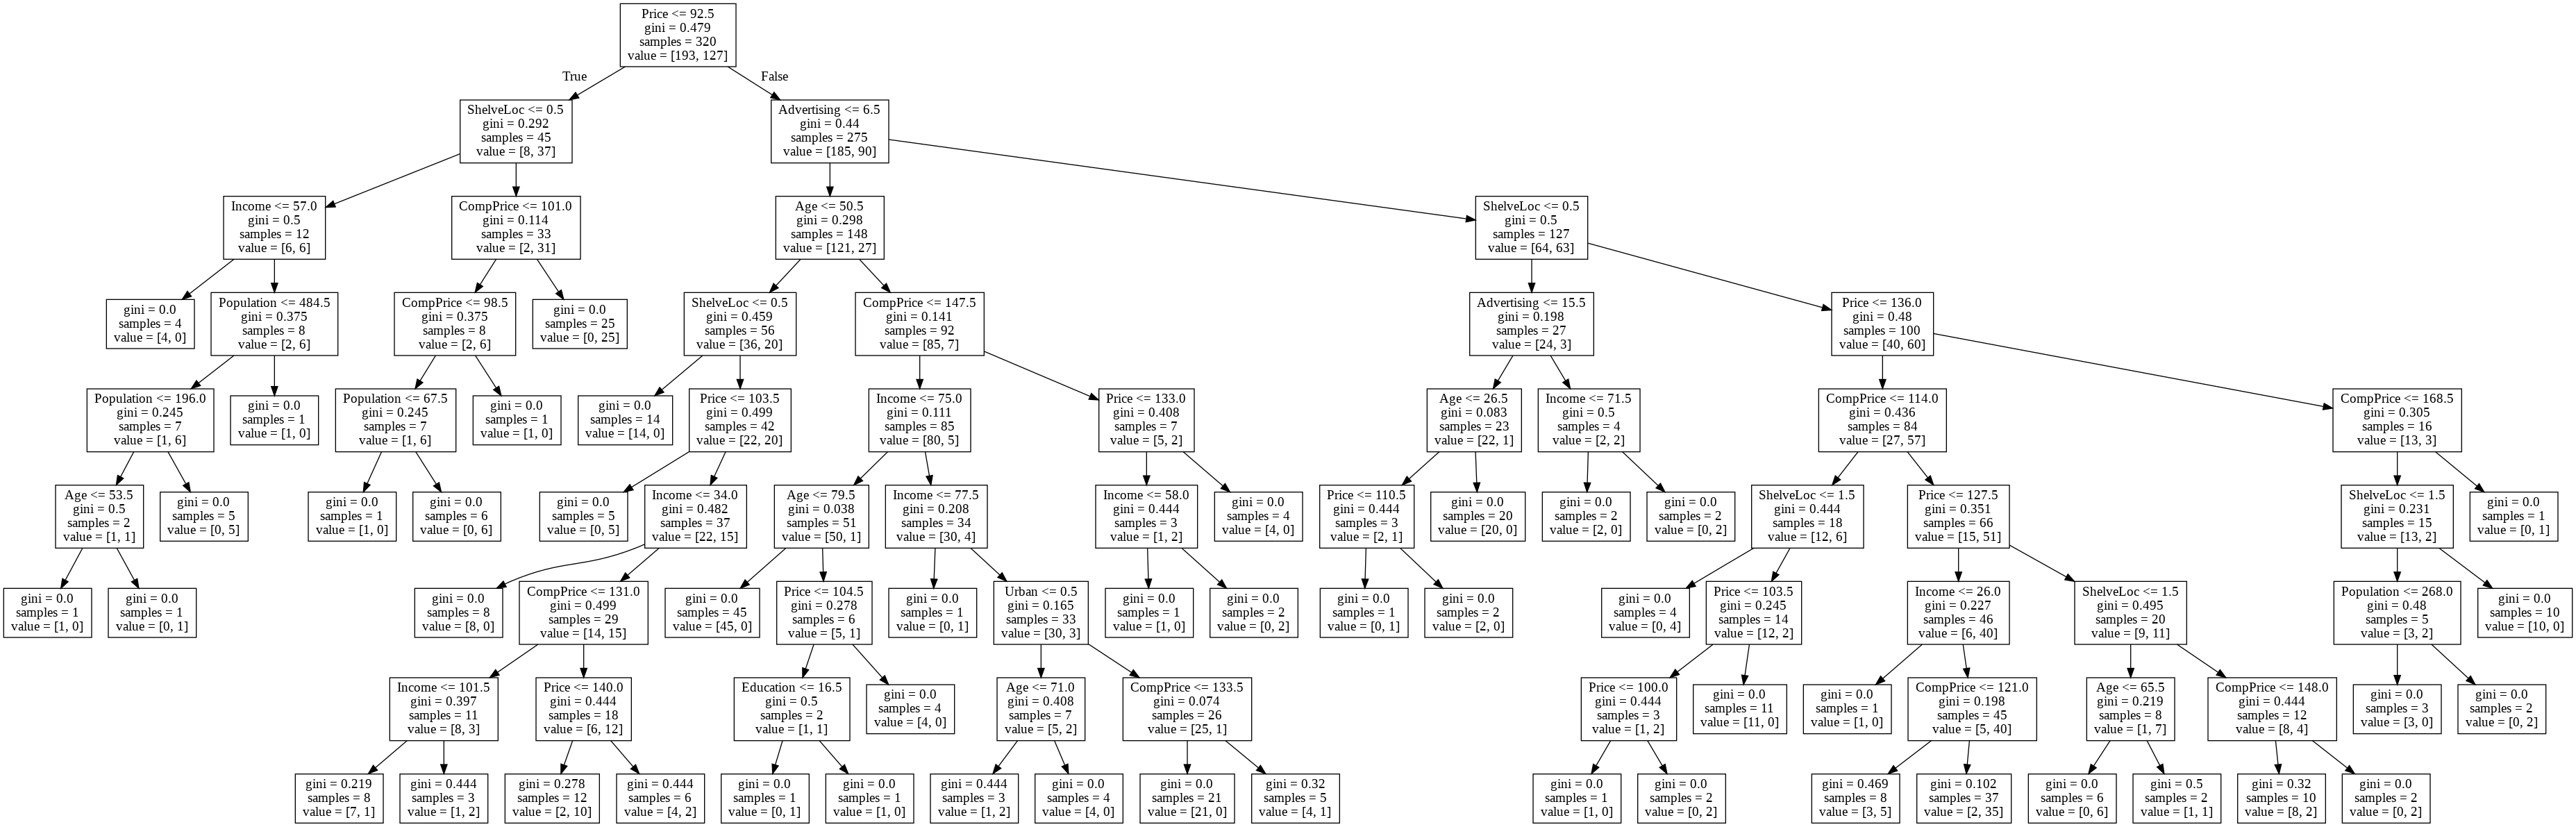

In [740]:
model = DecisionTreeClassifier(max_depth = depth+1)
model.fit(X_train, y_train)
dot_graph = tree.export_graphviz(model, out_file = None, feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_graph)
Image(graph.create_png())

In [0]:
img = Image(graph.create_png())
with open("carseat_tree3.png", "wb") as png:
    png.write(img.data)

In [742]:
pred = model.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index = ['No', 'Yes'], columns = ['No', 'Yes'])
print(cm)

     No  Yes
No   34   11
Yes   9   26


After finding the best depth the confusion matrix shows that our prediction improved as it was right 61/80 times. This gives us an accuracy of 76.25%. When tested with a larger depth value we can see that the prediction was right 60/80 times. Giving us a smaller accuracy of 75%.

In the assignment notebook we dont see a change in the prediction accuracy when increasing the value of best based on the confusion matrix as they both show that 155 out of 200 predictions were correct. 

These values can however change both in my notebook and in the assignment notebook based on the test-validation split.


In [0]:
df = pd.read_csv('/content/Boston.csv')
del df['Unnamed: 0']

In [744]:
X = df.drop('medv', axis = 1)
y = df.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
model = DecisionTreeRegressor(max_depth = 3)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8160292234821611

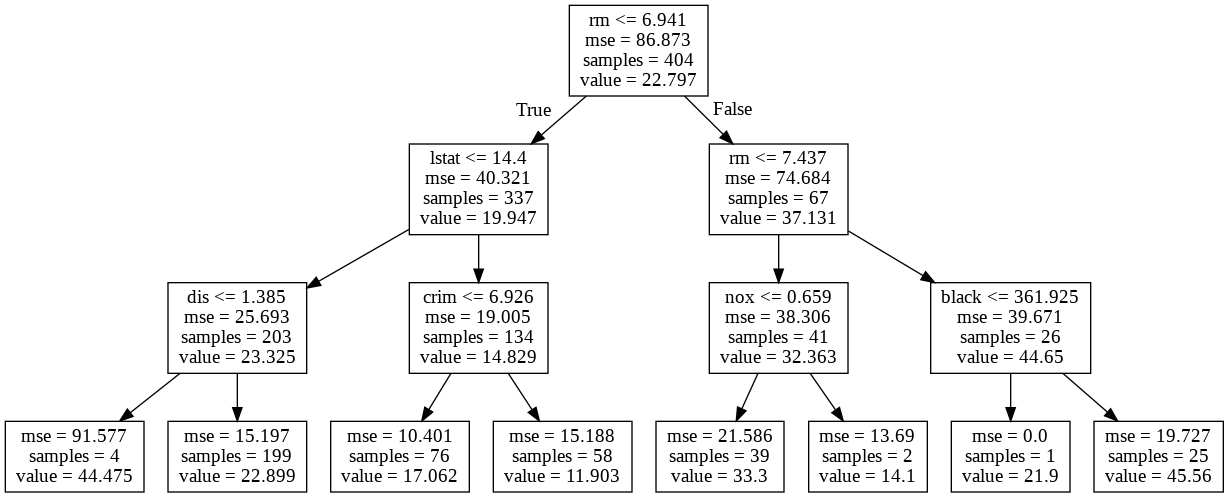

In [745]:
dot_graph = tree.export_graphviz(model, out_file = None, feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_graph)
Image(graph.create_png())

In [0]:
img = Image(graph.create_png())
with open("boston_tree.png", "wb") as png:
    png.write(img.data)

The DecisionTreeRegressor has a R^2 value of 0.81. In the assignment notebook we can see that just 4 values have been used in constructing the tree. In my case it was 5. The notebook also shows the sum of squared errors which is 10.38

Instead of gini the tree visualization shows MSE of each node and the MEDV value at each point in the tree. 

In [747]:
top_score = np.inf 
depth = 0
for i in range(1, 30): 
  tree = DecisionTreeRegressor(max_depth=i)
  tree.fit(X_train, y_train)
  pred = tree.predict(X_test)
  print("Depth: " , str(i) ," , MSE: " , mean_squared_error(y_test, pred))
  if mean_squared_error(y_test, pred) < top_score: 
     top_score = mean_squared_error(y_test,pred)
     depth = i
print("Best depth: ", depth, " , with MSE: ", top_score)

Depth:  1  , MSE:  46.91780325106487
Depth:  2  , MSE:  25.993190895971193
Depth:  3  , MSE:  13.491273032995432
Depth:  4  , MSE:  10.616592447744544
Depth:  5  , MSE:  8.55390658464684
Depth:  6  , MSE:  9.017528231099837
Depth:  7  , MSE:  20.98519901862533
Depth:  8  , MSE:  7.426020866925726
Depth:  9  , MSE:  15.288630699422095
Depth:  10  , MSE:  10.104953379375587
Depth:  11  , MSE:  22.525232812848657
Depth:  12  , MSE:  10.587559020969499
Depth:  13  , MSE:  9.757462958516738
Depth:  14  , MSE:  9.733289297385621
Depth:  15  , MSE:  12.28534765295007
Depth:  16  , MSE:  18.396296078431373
Depth:  17  , MSE:  11.014289215686274
Depth:  18  , MSE:  10.584926470588234
Depth:  19  , MSE:  16.83588235294118
Depth:  20  , MSE:  21.134117647058822
Depth:  21  , MSE:  13.074705882352943
Depth:  22  , MSE:  10.711862745098038
Depth:  23  , MSE:  9.221862745098038
Depth:  24  , MSE:  10.750882352941176
Depth:  25  , MSE:  10.235980392156865
Depth:  26  , MSE:  9.04294117647059
Depth:  

The pruning method present in the assignment notebook could not be replicated in Python and therefore i have implemented a method which finds the best max depth for the decision tree regressor. The best depth was found to be 8 as it had the lowest MSE of 7.42

The graph in the assignment notebook shows the error (dev) againts the number of terminal nodes (size) from the. From the graph we can see that larger the size the smaller the error. 

13.491273032995432

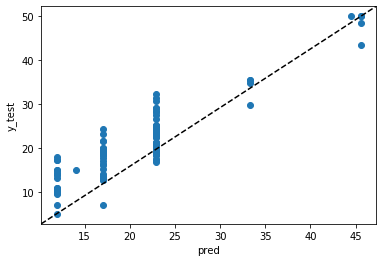

In [748]:
tree = DecisionTreeRegressor(max_depth=depth)
tree.fit(X_train, y_train)
pred = model.predict(X_test)
plt.scatter(pred, y_test, label = 'medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set prediction using the best depth results in an MSE of 13.49, the square root of the MSE is ~3.67 which shows that the test predicitons are within ~$3670 of the true medv value. 

In [749]:
bag_boston = RandomForestRegressor(max_features = 13, random_state = 1)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

8.516002372549016

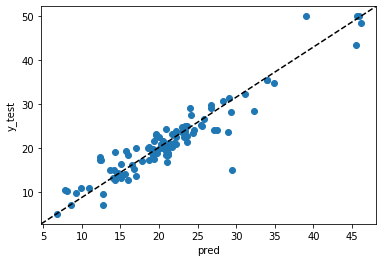

In [750]:
pred = bag_boston.predict(X_test)

plt.scatter(pred, y_test, label = 'medv')

plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

Changing the number of trees grown as seen in the Assignment notebook could not be replicated. The test prediction using 13 features yielded a MSE of 8.5 which is far better than the Decision tree regressor used previously. From the assignment notebook we can see that lowering the number of trees (ntree) yields a higher mean squared error. 



8.765178813725486

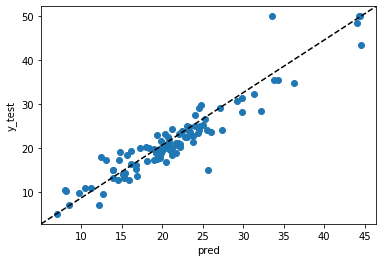

In [751]:
bag_boston = RandomForestRegressor(max_features = 6, random_state = 1)

bag_boston.fit(X_train, y_train)

pred = bag_boston.predict(X_test)

plt.scatter(pred, y_test, label = 'medv')

plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')
mean_squared_error(y_test, pred)

When we use less max features we can see that the test prediction yielded a higher MSE of 8.7 so it is worse than the previous RandomForestRegressor. 

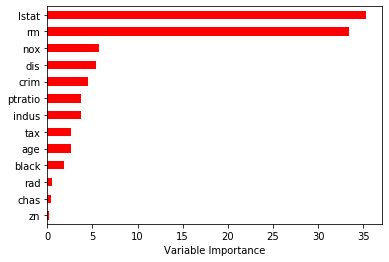

In [752]:
Importance = pd.DataFrame({'Importance':bag_boston.feature_importances_*100}, index = X.columns)
Importance.sort_values(by = 'Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

This bargraph shows us that the most important variables across all the treas in the regressor, the two most imporant ones are lstat and rm. From the assignment notebook we can see that removal of these two values results in the largest increases in mean squared error 32% and 27% for rm and lstat respectively. We can also see that the increase in node purity from splitting on the variable and averaging across all trees is the highest for rm and lstat. 

In [753]:
boosted_boston = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.01, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

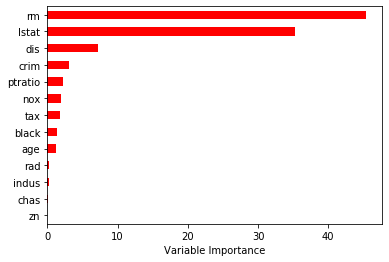

In [754]:
feature_importance = boosted_boston.feature_importances_*100
importance = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)
importance.T.plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [755]:
pred = boosted_boston.predict(X_test)
mean_squared_error(y_test, pred)

6.844978774839031

Again from this bargraph we can see that the most important variables by far are rm and lstat. The MSE obtained is superior (lower) than all other tested

7.108942604704232

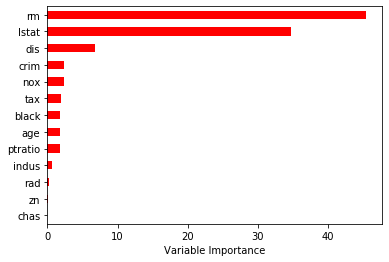

In [756]:
boosted_boston = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_boston.fit(X_train, y_train)
feature_importance = boosted_boston.feature_importances_*100
importance = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)
importance.T.plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
pred = boosted_boston.predict(X_test)
mean_squared_error(y_test, pred)

Text(0, 0.5, 'y_test')

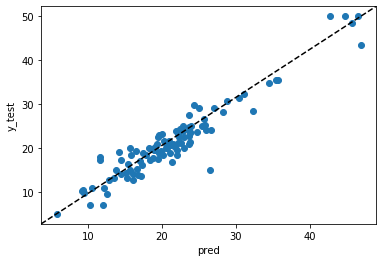

In [757]:
plt.scatter(pred, y_test, label = 'medv')

plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

Setting the shrinkage parameter from 0.01 to 0.2 has increased the mean squared error slightly from 6.8 to 7.1 The variable importance has stayed more or less the same with rm and lstat still being the most important. 